In [1]:
import init
import constants as cn
from mode_choice_calculator import ModeChoiceCalculator
from trip import BikeTrip, CarTrip, TransitTrip, WalkTrip
import visualize_geospatial_index as geoviz


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from collections import defaultdict

In [6]:
CAR_TIME_THRESHOLD = 15 #minutes
BIKE_TIME_THRESHOLD = 25 #minutes
TRANSIT_TIME_THRESHOLD = 60 #minutes
WALK_TIME_THRESHOLD = 45 #minutes
TRAVEL_HOURS = 12.0

In [7]:
# Read in data from Google Distance API
total_trips_df = pd.read_csv(cn.DISTANCES_OUT_FP)

In [8]:
total_trips_df

,address,block_group,city,class,departure_time,destination,distance,duration,duration_in_traffic,fare,lat,lon,mode,rating,type
0,NaN,530330020003,NaN,citywide,2018-07-25 12:00:00-07:00,Bellevue-Square,12.305780,18.716667,21.050000,NaN,47.615523,-122.199049,driving,NaN,Major Employment Area
1,NaN,530330028001,NaN,destination_park,2018-07-25 17:00:00-07:00,Greenlake Park,1.323182,6.650000,7.166667,NaN,47.680250,-122.328499,driving,NaN,NaN
2,3019 South Angeline Street,530330103001,Seattle,school,2018-07-25 17:00:00-07:00,Maxine Mimms High School,1.008701,5.633333,6.233333,NaN,47.559097,-122.292812,driving,NaN,NaN
3,NaN,530330104023,NaN,urban_village,2018-07-25 10:00:00-07:00,First Hill,4.466750,17.850000,19.416667,NaN,47.607908,-122.326042,driving,NaN,NaN
4,NaN,530330104023,NaN,citywide,2018-07-25 10:00:00-07:00,First Hill,4.466750,17.850000,19.416667,NaN,47.609422,-122.325120,driving,NaN,Major Employment Area
5,WA 98101,530330080012,Seattle,pharmacy,2018-07-25 12:00:00-07:00,"Donna Miles, RPh",0.450590,3.916667,4.016667,NaN,47.610767,-122.342636,driving,4.0,NaN
6,NaN,530330022001,NaN,citywide,2018-07-25 15:00:00-07:00,Downtown Pioneer Square,8.687383,18.866667,38.716667,NaN,47.601651,-122.334226,driving,NaN,Major Employment Area
7,4000 27th Avenue West,530330056001,Seattle,school,2018-07-25 10:00:00-07:00,Lawton Elementary School,2.132380,7.750000,7.716667,NaN,47.656743,-122.390398,driving,5.0,NaN
8,1000 4th Ave,530330080021,Seattle,library,2018-07-25 08:00:00-07:00,Seattle Public Library-Central Library,0.771908,6.350000,6.166667,NaN,47.606701,-122.332501,driving,4.7,NaN
9,NaN,530330042002,NaN,urban_village,2018-07-25 13:00:00-07:00,South Lake Union,7.276569,18.050000,22.050000,NaN,47.618809,-122.337972,driving,NaN,NaN


In [9]:
# Remove the trips where the destination is First Hill or SLU and the class of destination is urban_village
# These two locations are *only* citywides for each BG.
to_drop = total_trips_df[((total_trips_df.destination == "First Hill") | (total_trips_df.destination == "South Lake Union")) & (total_trips_df['class'] == "urban_village")]


In [10]:
total_trips_df = total_trips_df.drop(to_drop.index)

In [11]:
total_trips_df

,address,block_group,city,class,departure_time,destination,distance,duration,duration_in_traffic,fare,lat,lon,mode,rating,type
0,NaN,530330020003,NaN,citywide,2018-07-25 12:00:00-07:00,Bellevue-Square,12.305780,18.716667,21.050000,NaN,47.615523,-122.199049,driving,NaN,Major Employment Area
1,NaN,530330028001,NaN,destination_park,2018-07-25 17:00:00-07:00,Greenlake Park,1.323182,6.650000,7.166667,NaN,47.680250,-122.328499,driving,NaN,NaN
2,3019 South Angeline Street,530330103001,Seattle,school,2018-07-25 17:00:00-07:00,Maxine Mimms High School,1.008701,5.633333,6.233333,NaN,47.559097,-122.292812,driving,NaN,NaN
4,NaN,530330104023,NaN,citywide,2018-07-25 10:00:00-07:00,First Hill,4.466750,17.850000,19.416667,NaN,47.609422,-122.325120,driving,NaN,Major Employment Area
5,WA 98101,530330080012,Seattle,pharmacy,2018-07-25 12:00:00-07:00,"Donna Miles, RPh",0.450590,3.916667,4.016667,NaN,47.610767,-122.342636,driving,4.0,NaN
6,NaN,530330022001,NaN,citywide,2018-07-25 15:00:00-07:00,Downtown Pioneer Square,8.687383,18.866667,38.716667,NaN,47.601651,-122.334226,driving,NaN,Major Employment Area
7,4000 27th Avenue West,530330056001,Seattle,school,2018-07-25 10:00:00-07:00,Lawton Elementary School,2.132380,7.750000,7.716667,NaN,47.656743,-122.390398,driving,5.0,NaN
8,1000 4th Ave,530330080021,Seattle,library,2018-07-25 08:00:00-07:00,Seattle Public Library-Central Library,0.771908,6.350000,6.166667,NaN,47.606701,-122.332501,driving,4.7,NaN
10,NaN,530330042002,NaN,citywide,2018-07-25 13:00:00-07:00,South Lake Union,7.276569,18.050000,22.050000,NaN,47.622933,-122.337105,driving,NaN,Major Employment Area
11,NaN,530330069004,NaN,citywide,2018-07-25 19:00:00-07:00,South Seattle College,9.596022,20.133333,21.083333,NaN,47.548410,-122.352194,driving,NaN,College


In [8]:
for mode in [cn.DRIVING_MODE, cn.BIKING_MODE, cn.TRANSIT_MODE, cn.WALKING_MODE]:
    mean_duration = total_trips_df[total_trips_df['mode'] == mode]['duration'].mean()
    print("Mean duration for {0} trips: {1}".format(mode, mean_duration))
    
    max_duration = total_trips_df[total_trips_df['mode'] == mode]['duration'].max()
    print("Max duration for {0} trips: {1}\n".format(mode, max_duration))
    if mode == cn.DRIVING_MODE or mode == cn.TRANSIT_MODE:
        mean_duration_in_traffic = total_trips_df[total_trips_df['mode'] == mode]['duration_in_traffic'].mean()
        print("Mean duration for {0} in traffic: {1}".format(mode, mean_duration_in_traffic))
        
        max_duration_in_traffic = total_trips_df[total_trips_df['mode'] == mode]['duration_in_traffic'].max()
        print("Max duration for {0} in traffic: {1}\n".format(mode, max_duration_in_traffic))

Mean duration for driving trips: 11.012465696465975
Max duration for driving trips: 38.53333333333333

Mean duration for driving in traffic: 13.09939469182155
Max duration for driving in traffic: 55.08333333333334

Mean duration for bicycling trips: 26.524489258489236
Max duration for bicycling trips: 116.86666666666666

Mean duration for transit trips: 11106.645559735125
Max duration for transit trips: 71582787.7

Mean duration for transit in traffic: nan
Max duration for transit in traffic: nan

Mean duration for walking trips: 73.15454331254335
Max duration for walking trips: 335.8833333333333



In [9]:
psrc_df = pd.read_csv('data/raw/Trip_Household_Merged.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
psrc_df

,tripid,hhid,origin_lat,origin_lng,dest_lat,dest_lng,bg_origin,bg_dest,personid,google_duration,...,tenure,race_afam,race_aiak,race_asian,race_hapi,race_white,race_other,race_hisp,race_total,pct_white
0,1.710000e+12,17119958,47.707597,-122.118828,999.000000,999.000000,530330323213,none,1711995801,4.0,...,Between 3 and 5 years,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
1,1.710000e+12,17119958,47.707597,-122.118828,999.000000,999.000000,530330323213,none,1711995803,4.0,...,Between 3 and 5 years,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
2,1.710000e+12,17119958,47.707597,-122.118828,999.000000,999.000000,530330323213,none,1711995804,4.0,...,Between 3 and 5 years,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
3,1.710000e+12,17108513,34.857550,132.033550,31.687940,124.343310,none,none,1710851301,54.0,...,Between 2 and 3 years,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0
4,1.710000e+12,17108513,31.150120,121.798040,31.316290,120.660290,none,none,1710851301,118.0,...,Between 2 and 3 years,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0
5,1.710000e+12,17108513,31.316290,120.660290,31.325580,120.517380,none,none,1710851301,40.0,...,Between 2 and 3 years,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0
6,1.710000e+12,17132862,39.983014,116.460013,39.986479,116.460180,none,none,1713286201,4.0,...,Between 1 and 2 years,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
7,1.710000e+12,17132862,39.973713,116.276579,39.986479,116.460180,none,none,1713286201,25.0,...,Between 1 and 2 years,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
8,1.710000e+12,17132862,39.986479,116.460180,39.983014,116.460013,none,none,1713286201,4.0,...,Between 1 and 2 years,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
9,1.710000e+12,17132862,39.986479,116.460180,39.973713,116.276579,none,none,1713286201,22.0,...,Between 1 and 2 years,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0


In [11]:
psrc_df['mode'].value_counts()

Drive Alone       18242
Drive w Others    15206
Walk              10838
Transit            4050
Other              2945
Bike               1199
Name: mode, dtype: int64

Mean duration for Drive Alone trips: 17.581553557723936
Max duration for Drive Alone trips: 1801.0



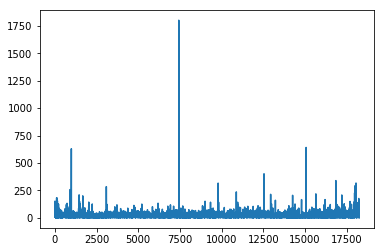

Mean duration for Drive w Others trips: 16.64145731947915
Max duration for Drive w Others trips: 1246.0



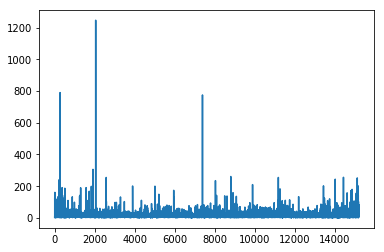

Mean duration for Walk trips: 11.938457279940948
Max duration for Walk trips: 620.0



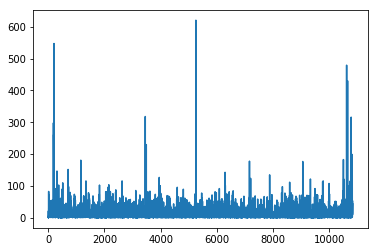

Mean duration for Transit trips: 29.004444444444445
Max duration for Transit trips: 537.0



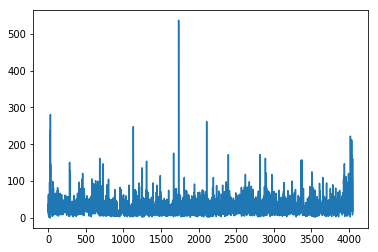

Mean duration for Bike trips: 21.65304420350292
Max duration for Bike trips: 535.0



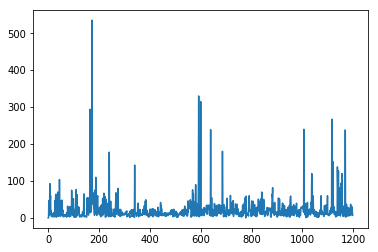

In [12]:
for mode in ['Drive Alone', 'Drive w Others', 'Walk', 'Transit', 'Bike']:
    mean_duration = psrc_df[psrc_df['mode'] == mode]['google_duration'].mean()
    print("Mean duration for {0} trips: {1}".format(mode, mean_duration))
    max_duration = psrc_df[psrc_df['mode'] == mode]['google_duration'].max()
    print("Max duration for {0} trips: {1}\n".format(mode, max_duration))
    
    rng = psrc_df[psrc_df['mode'] == mode]['google_duration'].values
    plt.plot(rng)
    plt.show()

In [12]:
def trip_from_row(row):
        """
        Given a dataframe with the available variables, create a trip class 
        with these variables. Returns trip.
        """

        origin = row[cn.BLOCK_GROUP] 
        dest_lat = row[cn.LAT]
        dest_lon = row[cn.LON]
        
        mode = row[cn.MODE]
        distance = row[cn.DISTANCE]
        duration = row[cn.DURATION]
        duration_in_traffic = row[cn.DURATION_IN_TRAFFIC]
        fare_value = row[cn.FARE_VALUE]
        # the attributes initiated to None is because we currently don't have 
        # them. We might need to revise the trip class to eliminate them or the data to have
        # the necesary data.
        basket_category = None
        #convert departure time to date-time object
        departure_time = row[cn.DEPARTURE_TIME]
        trip = {cn.DRIVING_MODE: CarTrip(origin, dest_lat, dest_lon, distance,
                                              duration, basket_category, departure_time, duration_in_traffic=duration_in_traffic),
        cn.TRANSIT_MODE: TransitTrip(origin, dest_lat, dest_lon, distance, duration,
                                          basket_category, departure_time, fare_value=fare_value),
        cn.BIKING_MODE: BikeTrip(origin, dest_lat, dest_lon, distance, duration,
                                      basket_category, departure_time),
        cn.WALKING_MODE: WalkTrip(origin, dest_lat, dest_lon, distance, duration,
                                       basket_category, departure_time)}[mode]
        
        # trip = Trip(origin, dest_lat, dest_lon, departure_time, mode, distance, duration, basket_category)
        return trip

In [13]:
def is_viable(trip):
        """
        This function takes in a Trip and returns a value indicating whether a trip is viable (1) or
        not viable (0) as a fuction of trip.mode and trip.duration.
        """


        # We might need to adjust this such that it operates on DF rows,
        # not Trip objects.
        viable = 0
        if trip.mode == cn.DRIVING_MODE and trip.duration < CAR_TIME_THRESHOLD:
            viable = 1
        elif trip.mode == cn.BIKING_MODE and trip.duration < BIKE_TIME_THRESHOLD:
            viable = 1
        elif trip.mode == cn.TRANSIT_MODE and trip.duration < TRANSIT_TIME_THRESHOLD:
            viable = 1
        elif trip.mode == cn.WALKING_MODE and trip.duration < WALK_TIME_THRESHOLD:
            viable = 1

            #can we take into account proximity? thinking of nearby locations with bad connections
            # or disnant locations with good connections. Most relevant for bus.

        
        return viable

In [14]:
def create_blockgroup_dict(df):
        """
        adds a column for viable or not
        """
        blkgrp_dict = defaultdict(list)
        for _, row in df.iterrows():
            trip = trip_from_row(row)
            blkgrp = trip.origin
            viable = is_viable(trip)
            trip.set_viability(viable)
            blkgrp_dict[blkgrp].append(trip)

        return blkgrp_dict

In [15]:
def calculate_mode_avail(trips):
        """
        Input: trips (list of Trips)
        Output: mode index for the list of trips as a function of viability
        """
        # Hours of data availability, HOURS constant should be float
        scores = {}
        for mode in [cn.DRIVING_MODE, cn.BIKING_MODE, cn.TRANSIT_MODE, cn.WALKING_MODE]:
            mode_avail = sum([trip.viable for trip in trips if trip.mode == mode])
            mode_index = mode_avail
            if mode == cn.DRIVING_MODE or mode == cn.TRANSIT_MODE:
                mode_index /= 14.0 #(?) name constant
            mode_index /= float(25) # Yay! no more dupes
            scores[mode] = mode_index
        return scores


In [16]:
def trips_per_blockgroup(df, viable_only=False):
        """
        Inputs:
            df (Dataframe)
            viable_only (Boolean)
        Outputs:
            blkgrp_dict (dict)
        
        Given a dataframe containing data for one trip per row,  
        instantiate a trip for each row, calculate its viability,
        and aggregate the trips for each blockgroup.
    
        If viable_only == True, only append the viable trips to the lists. 

        Return a dict where keys are blockgroups and values are lists of Trips.
        """
        blkgrp_dict = defaultdict(list)
        for _, row in df.iterrows():
            trip = trip_from_row(row)
            blkgrp = trip.origin

            viable = is_viable(trip)
            trip.set_viability(viable)
            if viable_only:
                if viable == 1:
                    blkgrp_dict[blkgrp].append(trip)
            else:
                blkgrp_dict[blkgrp].append(trip)

        return blkgrp_dict

In [17]:
def df_from_dict(data_dict):
    data = []
    for blkgrp, trips in data_dict.items():
        mode_scores = calculate_mode_avail(trips)
        row = mode_scores
        mode_index = sum(mode_scores.values()) / 4
        row[cn.BLOCK_GROUP] =  blkgrp
        row[cn.MODE_CHOICE_INDEX] = mode_index
        data.append(row)
    df = pd.DataFrame(data, columns=[cn.BLOCK_GROUP, cn.DRIVING_MODE, cn.BIKING_MODE, cn.TRANSIT_MODE, cn.WALKING_MODE, cn.MODE_CHOICE_INDEX])
    return df

In [18]:
d = trips_per_blockgroup(total_trips_df)

In [22]:
big_df = df_from_dict(d)

In [23]:
big_df

,block_group,driving,bicycling,transit,walking,mode_index
0,530330020003,0.662857,0.60,0.951429,0.56,0.693571
1,530330028001,0.591429,0.60,0.942857,0.52,0.663571
2,530330103001,0.485714,0.48,0.928571,0.48,0.593571
3,530330104023,0.611429,0.56,0.942857,0.48,0.648571
4,530330080012,0.774286,0.80,1.000000,0.76,0.833571
5,530330022001,0.560000,0.48,0.757143,0.40,0.549286
6,530330056001,0.408571,0.40,0.728571,0.24,0.444286
7,530330080021,0.785714,0.80,1.000000,0.80,0.846429
8,530330042002,0.537143,0.52,0.925714,0.52,0.625714
9,530330069004,0.520000,0.60,0.951429,0.48,0.637857


In [24]:
big_df.sort_values(by='mode_index')

,block_group,driving,bicycling,transit,walking,mode_index
310,530330121001,0.480000,0.28,0.680000,0.24,0.420000
75,530330057001,0.440000,0.40,0.654286,0.24,0.433571
362,530330056002,0.434286,0.36,0.702857,0.24,0.434286
6,530330056001,0.408571,0.40,0.728571,0.24,0.444286
348,530330022004,0.520000,0.52,0.480000,0.32,0.460000
230,530330056004,0.480000,0.28,0.802857,0.28,0.460714
458,530330056003,0.480000,0.32,0.822857,0.28,0.475714
85,530330063001,0.488571,0.28,0.911429,0.24,0.480000
262,530330260011,0.480000,0.48,0.617143,0.40,0.494286
248,530330057004,0.468571,0.44,0.840000,0.24,0.497143


In [19]:
car_trip = d[530330020003][0]

In [20]:
car_trip.distance


12.30577998756992

In [21]:
car_trip.mode

'driving'

In [25]:
big_df.to_csv('sample_mode_choice.csv')